# __Biodiversity in National Parks__

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations.

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.

Here are a few questions that this project has sought to answer:

1. What is the distribution of conservation status among species?
2. Are there any patterns between the number of observations and the proportion of species being protected?

**Data sources:**

Both `Observations.csv` and `Species_info.csv` was provided by Codecademy.

Note: The data for this project is *inspired* by real data, but is mostly fictional.

In [607]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from scipy.stats import chi2_contingency

# 1. Load the data

#### species

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status


In [388]:
species = pd.read_csv('./data/species_info.csv')

print(f"species shape: {species.shape}")
species.head()

species shape: (5824, 4)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


#### observations

The `Observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [389]:
obs = pd.read_csv('./data/observations.csv')

print(f"observations shape: {obs.shape}")
obs.head()

observations shape: (23296, 3)


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


As two dataset seems to have same colum `scientific_name`, we will merge two data to one dataset.

In [416]:
df = species.merge(obs, how='outer')

df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Bryce National Park,109
1,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Yellowstone National Park,215
2,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Great Smoky Mountains National Park,72
3,Vascular Plant,Abies bifolia,Rocky Mountain Alpine Fir,NaN,Yosemite National Park,136
4,Vascular Plant,Abies concolor,"Balsam Fir, Colorado Fir, Concolor Fir, Silver...",NaN,Great Smoky Mountains National Park,101


# 2. Explore the Data

### `category` column

In [417]:
# distinct categories
print(f'number of categories: {df.category.nunique()}')
print(f'categories: {df.category.unique()}')

# distinct species
print(f'number of species: {df.scientific_name.nunique()}')

# number of species in each category
species.groupby("category").size().reset_index(name='count')

number of categories: 7
categories: ['Vascular Plant' 'Nonvascular Plant' 'Bird' 'Amphibian' 'Reptile'
 'Mammal' 'Fish']
number of species: 5541


,category,count
0,Amphibian,80
1,Bird,521
2,Fish,127
3,Mammal,214
4,Nonvascular Plant,333
5,Reptile,79
6,Vascular Plant,4470


In this analysis, we will just focus on animals.

In [418]:
df = df[~df.category.isin(['Nonvascular Plant', 'Vascular Plant'])]

print(f'animal categories: {df.category.unique()}')

animal categories: ['Bird' 'Amphibian' 'Reptile' 'Mammal' 'Fish']


### `conservation_status` column

In [419]:
print(f"number of conservation statuses:{df.conservation_status.nunique()}")
print(f"unique conservation statuses:{df.conservation_status.unique()}")

number of conservation statuses:4
unique conservation statuses:[nan 'Species of Concern' 'Threatened' 'Endangered' 'In Recovery']


In [420]:
# Group by 'conservation_status' and count unique 'scientific_name' in each group
conservation_counts = df.groupby('conservation_status')['scientific_name'].nunique().reset_index(name='count')

conservation_counts

,conservation_status,count
0,Endangered,14
1,In Recovery,4
2,Species of Concern,103
3,Threatened,8


### `park_name` column

In [421]:
print(f"number of parks:{df.park_name.nunique()}")
print(f"unique parks:{df.park_name.unique()}")

number of parks:4
unique parks:['Great Smoky Mountains National Park' 'Bryce National Park'
 'Yosemite National Park' 'Yellowstone National Park']


# 3. Analyze the Data

Before analyzing, I will fill the NA values in `conservation_status` with 'Not Protected'.

In [457]:
# fill NA values with 'Not Protected'
df['conservation_status'] = df['conservation_status'].fillna('Not Protected')

df['conservation_status'].isna().sum()

0

## 3-1. Distribution of conservation status

In [450]:
# set the order of the status
category_order = ['Not Protected', 'Species of Concern', 'Threatened', 'Endangered', 'In Recovery']
df['conservation_status'] = pd.Categorical(df['conservation_status'], categories=category_order, ordered=True)

# select the protected species
# count the number of unique rows (species)
# make it easier to read
pivot_df = df[df['conservation_status'] != 'Not Protected'].groupby(['conservation_status', 'category'], observed=False)['scientific_name']\
    .nunique().reset_index(name='count')\
    .pivot(index='conservation_status', columns='category', values='count')

# fill NA with 0, and change to integer
pivot_df.fillna(0).astype(int)
pivot_df = pivot_df.loc[pivot_df.index != 'Not Protected']
pivot_df

category,Amphibian,Bird,Fish,Mammal,Reptile
conservation_status,,,,,
Species of Concern,4,68,4,22,5
Threatened,2,0,4,2,0
Endangered,1,4,3,6,0
In Recovery,0,3,0,1,0


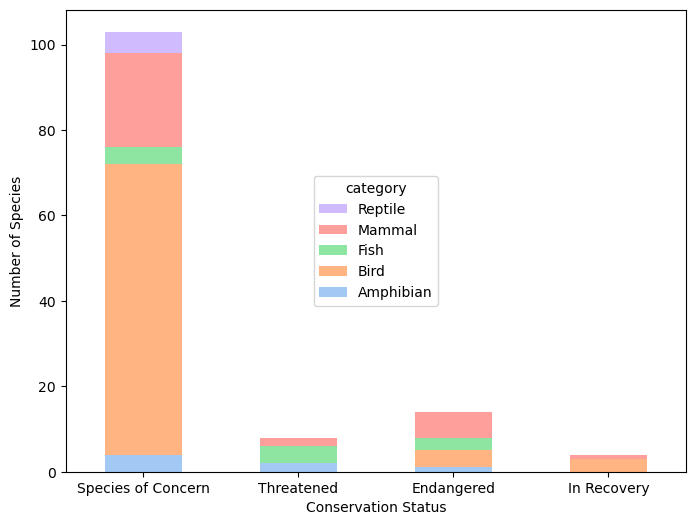

In [652]:
# plot the distribution of conservation status
palette = sns.color_palette("pastel")

ax = pivot_df.plot(kind = 'bar', figsize=(8,6), stacked=True, color=palette)
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="category", loc=10) # change the order of the legend
plt.savefig('./plot/conservation_status.png')
plt.show()

## 3-2. Number of Observations and Protection Percentages

To analyze the second question, we are going to create the column `is_protected` and `simple_name` for analyzing the data.

In [559]:
# create 'is_protected' column whether the species are protected
df['is_protected'] = df['conservation_status'] != 'Not Protected'

df.head()

,category,scientific_name,common_names,conservation_status,park_name,observations,is_protected,simple_name
40,Bird,Acanthus flammea,"Common Redpoll, Redpoll",Not Protected,Great Smoky Mountains National Park,68,False,Redpoll
41,Bird,Acanthus flammea,"Common Redpoll, Redpoll",Not Protected,Bryce National Park,95,False,Redpoll
42,Bird,Acanthus flammea,"Common Redpoll, Redpoll",Not Protected,Yosemite National Park,120,False,Redpoll
43,Bird,Acanthus flammea,"Common Redpoll, Redpoll",Not Protected,Yellowstone National Park,241,False,Redpoll
44,Bird,Accipiter cooperii,Cooper's Hawk,Species of Concern,Bryce National Park,95,True,Hawk


To create `simple_name`, I will use the `common_names` column and extract the simple name of each species.

In [459]:
# unique common_names
df.common_names.unique()[0:20]

array(['Common Redpoll, Redpoll', "Cooper's Hawk", 'Northern Goshawk',
       'Sharp-Shinned Hawk', 'Northern Cricket Frog', 'Spotted Sandpiper',
       "Clark's Grebe", 'Western Grebe', 'Saw-Whet Owls',
       'Northern Saw-Whet Owl', 'Boreal Owl', 'White-Throated Swift',
       'Red-Winged Blackbird', 'Northern Copperhead', "Bachman's Sparrow",
       'Rufous-Crowned Sparrow', 'Wood Duck', 'Eurasian Elk, Moose',
       'Yellowstone Moose', 'Chukar'], dtype=object)

When we take a look at the names, we can find out that the simple names are usually in the last word. Exception is that there are parenthesis. In this case, we can ignore the word in the parenthesis and use the word emerging right next to the parenthesis.

In [460]:
# Find the simple name using the regular expression
df['simple_name'] = df['common_names'].str.extract(r'(?:\(|\b)(\w+)\)?$')

# Make 'Owls' -> 'Owl'
df['simple_name'] = df['simple_name'].str.replace('Owls', 'Owl', regex=False)

df['simple_name'].unique()[0:20]

array(['Redpoll', 'Hawk', 'Goshawk', 'Frog', 'Sandpiper', 'Grebe', 'Owl',
       'Swift', 'Blackbird', 'Copperhead', 'Sparrow', 'Duck', 'Moose',
       'Chukar', 'Partridge', 'Bass', 'Salamander', 'Bullhead', 'Pintail',
       'Wigeon'], dtype=object)

Next, let's calculate the total observations and the percentage of being protected based on simple_name.

In [571]:
# calcuate the total observations of each simple_name
total_observations = (df.groupby('simple_name')['observations']
    .sum()
    .reset_index(name='total_observations'))

# drop the duplicated rows (caused by merging national parks data)
unique_df = df.drop_duplicates('scientific_name')

# calculate the protected_percentage of each simple_name
protected_percentage = (unique_df.groupby('simple_name')['is_protected']
    .mean()
    .reset_index(name='protected_percent')
    .sort_values(by='protected_percent', ascending=False))

# merge two data and add the category
protected_percent_df = total_observations.merge(protected_percentage, on='simple_name')
protected_percent_df = protected_percent_df.merge(df[['simple_name', 'category', 'conservation_status']].drop_duplicates('simple_name'), on='simple_name', how='left')

protected_percent_df.head()

,simple_name,total_observations,protected_percent,category,conservation_status
0,Anole,626,0.000000,Reptile,Not Protected
1,Avocet,535,0.000000,Bird,Not Protected
2,Badger,2000,1.000000,Mammal,Species of Concern
3,Bass,2885,0.000000,Fish,Not Protected
4,Bat,13828,0.384615,Mammal,Species of Concern


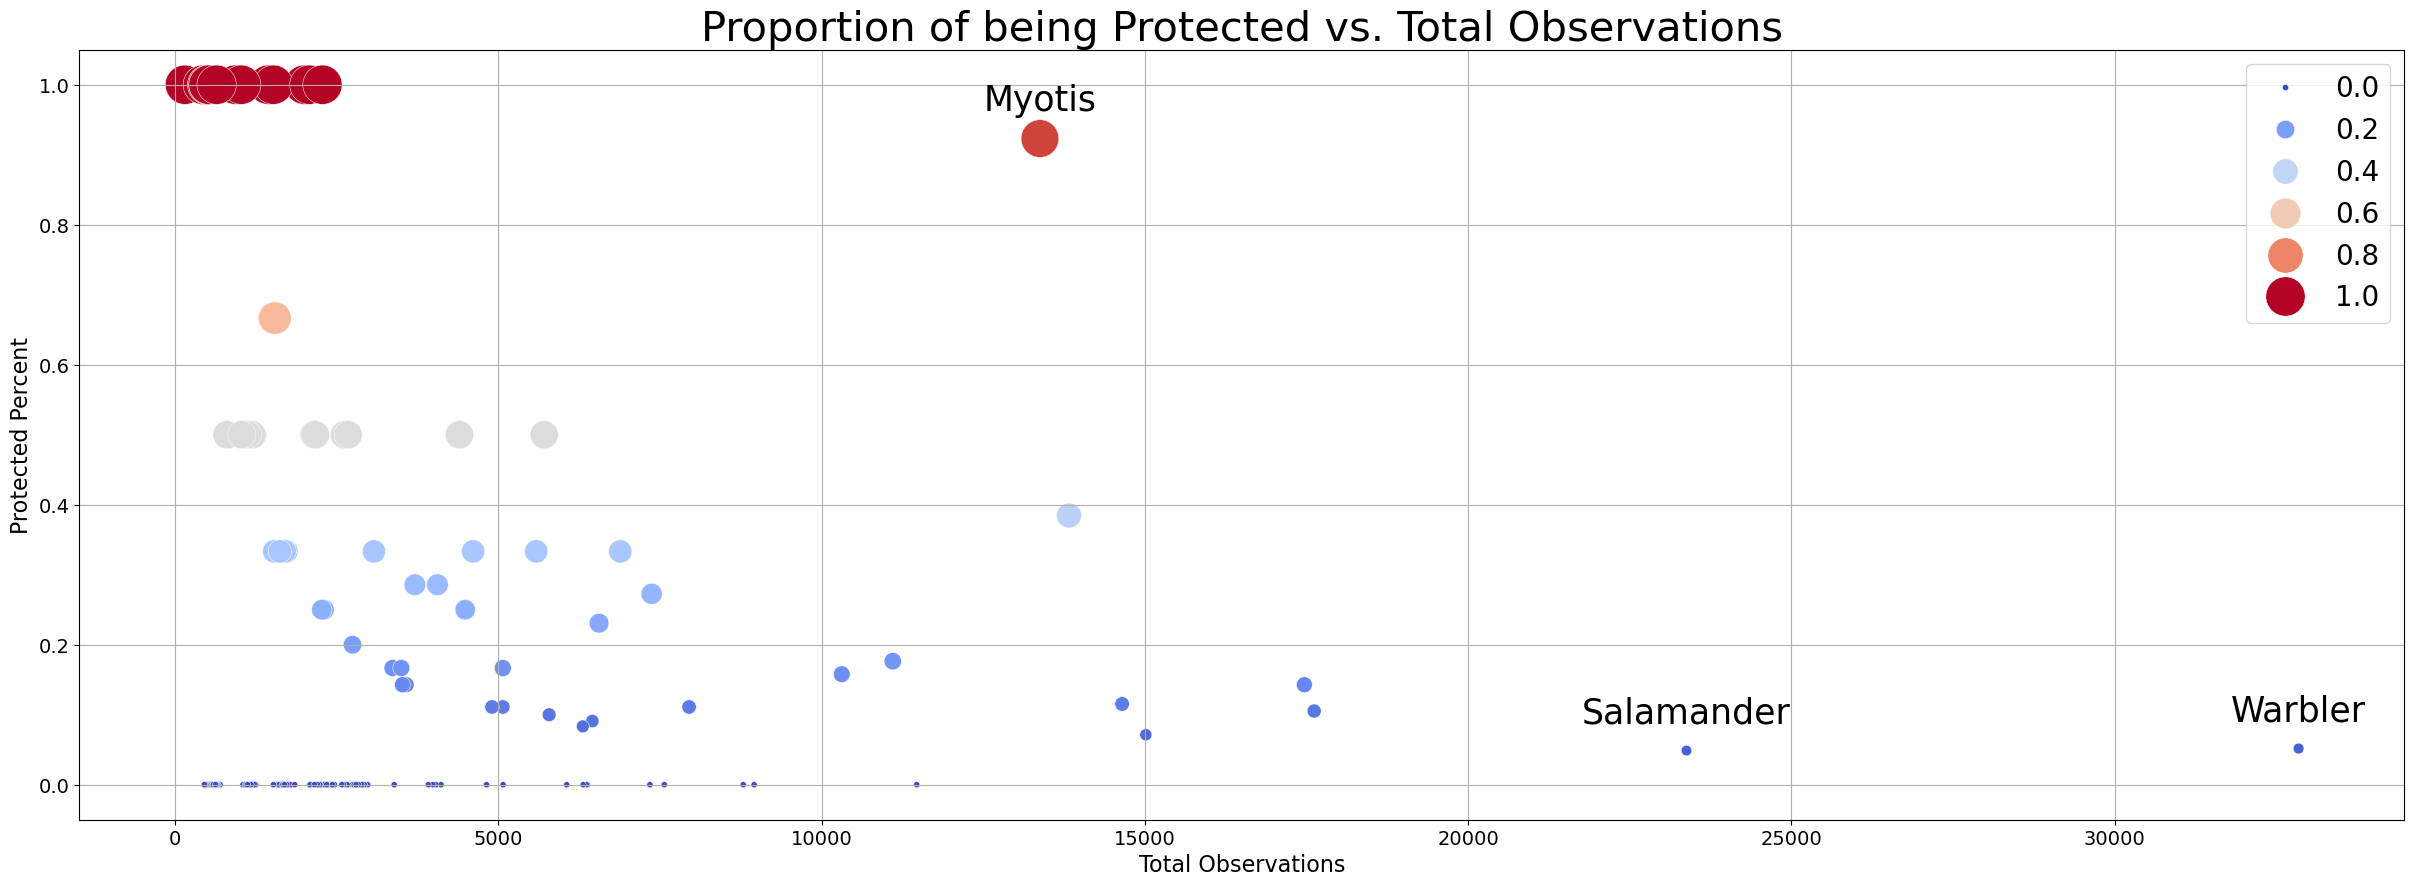

In [653]:
# create the scatterplot
palette = sns.color_palette("coolwarm")

plt.figure(figsize=(30, 10))
sns.scatterplot(
    x='total_observations',
    y='protected_percent',
    size='protected_percent',
    sizes=(20, 800),
    data=protected_percent_df,
    legend=True,
    hue='protected_percent',
    palette='coolwarm'
)
# plt.xlim(0, 8000)
plt.title('Proportion of being Protected vs. Total Observations', fontsize=30)
plt.xlabel('Total Observations', fontsize=16)
plt.ylabel('Protected Percent', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.legend(fontsize=20)

# interesting points: not following the overall trend
high_protected = protected_percent_df[(protected_percent_df['total_observations'] > 20000) | ((protected_percent_df['total_observations'] > 10000) & (protected_percent_df['protected_percent'] > 0.8))]

# show the simple name of the interesting points
for _, row in high_protected.iterrows():
    plt.annotate(
        row['simple_name'],
        (row['total_observations'], row['protected_percent']),
        textcoords="offset points",
        xytext=(0, 20),
        ha='center',
        fontsize=25,
        color='black'
    )
plt.savefig('./plot/observation_protection.png')

plt.show()

Based on the scatterplot, we can observe some interesting insights, which may be considered as outliers from the overall trend.

First, there is one animal with an exceptionally high number of observations: the "Warbler," followed by the "Salamander" with the second-highest count.

Second, the plot shows that, in general, animals with a large number of observations tend to be less protected. However, "Myotis" stands out as it is mostly protected despite having a relatively high number of observations. Given that Myotis is categorized as a "Species of Concern," it is possible that its population has been rapidly declining recently (look at the following code).

In [575]:
protected_percent_df[protected_percent_df['simple_name'] == 'Myotis']

,simple_name,total_observations,protected_percent,category,conservation_status
142,Myotis,13378,0.923077,Mammal,Species of Concern


Next, let's take a look at the points with total observations between 0 and 10,000.

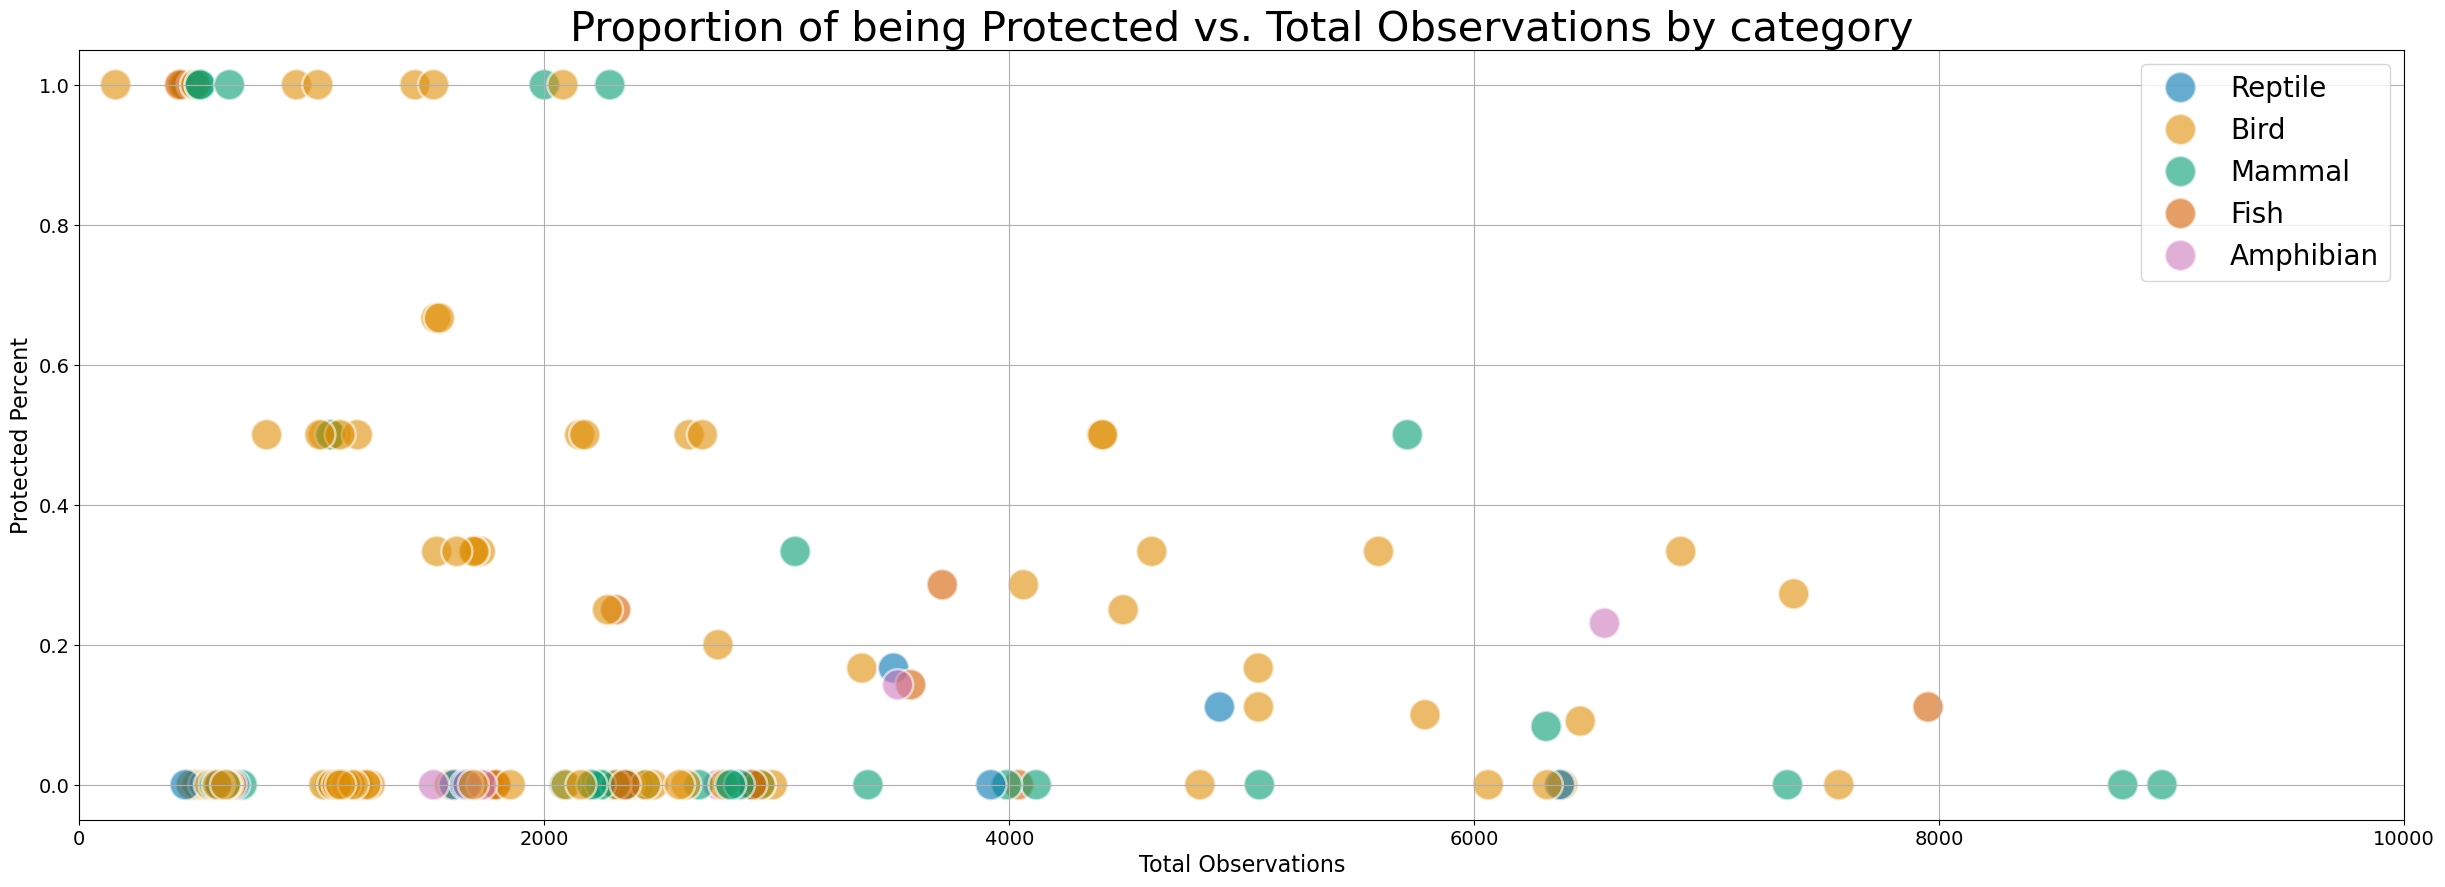

In [654]:
palette = sns.color_palette("coolwarm")

plt.figure(figsize=(30, 10))
scatter = sns.scatterplot(
    x='total_observations',
    y='protected_percent',
    s=500,
    alpha=0.6,
    hue='category',
    palette='colorblind',
    data=protected_percent_df,
    # data=protected_percent_df[protected_percent_df['category'] != 'Bird']
)

plt.legend(fontsize=20)

plt.xlim(0, 10000)
plt.title('Proportion of being Protected vs. Total Observations by category', fontsize=30)
plt.xlabel('Total Observations', fontsize=16)
plt.ylabel('Protected Percent', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.savefig('./plot/observation_protection_species.png')
plt.show()


We can tell birds are spred all over the points, and mammals tends to have larger total observations and higher protected percent, while reptile has less total observations and less protected percent. To check whether this is a significant difference, we can conduct a chi-squared test.

#### Statistical Significance

 In order to run a chi squared test, a contingency table will need to be created. The contingency table should look like this:

In [614]:
df[df['category'].isin(['Mammal', 'Reptile'])]\
    .groupby(['category', 'is_protected'])['scientific_name'].nunique().reset_index(name='count')\
    .pivot(index='category', columns='is_protected', values='count').reset_index()

is_protected,category,False,True
0,Mammal,146,30
1,Reptile,73,5


In [612]:
contingency = [[146, 30],
              [73, 5]]
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=4.289183096203645, pvalue=0.03835559022969898, dof=1, expected_freq=array([[151.7480315,  24.2519685],
       [ 67.2519685,  10.7480315]]))

The p-value is 0.039 which is below the standard threshold of 0.05 which can be take that the difference between reptile and mammal is statistically significant. Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles.

# Conclusions

The project was able to make several data visualizations and inferences about the various species in four of the National Parks that comprised this data set.

This project was also able to answer some of the questions first posed in the beginning:

- What is the distribution of conservation status among species?
    - The __vast majority of species are not part of conservation efforts__.(5,633 vs 191)
- Are there any patterns between the number of observations and the proportion of species being protected?
    - Animals with __more observations tend to have a lower protection percentage__, though there is an outlier: Myotis, which has a high protection percentage despite having a relatively large number of observations.